In [31]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [32]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(22),
     transforms.Scale(32),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

trainset = torchvision.datasets.CIFAR10(root='./datasets/CIFAR-10', train=True,
                                        download=True, transform=transform)

# testset = torchvision.datasets.CIFAR10(root='./datasets/CIFAR-10', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset) / 100,
#                                          shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [33]:
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

testset = torchvision.datasets.CIFAR10(root='./datasets/CIFAR-10', train=False,
                                        download=True, transform=transform)
testloader1 = torch.utils.data.DataLoader(testset, batch_size=len(testset),
                                          shuffle=False, num_workers=1)
testloader2 = torch.utils.data.DataLoader(testset, batch_size=len(testset)/100,
                                          shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [34]:
# transform = transforms.Compose(
#     [transforms.RandomHorizontalFlip(),
#      transforms.RandomCrop(22),
#      transforms.Scale(32),
#      transforms.ToTensor(),
#      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

# trainset = torchvision.datasets.CIFAR10(root='./datasets/CIFAR-10', train=True,
#                                         download=True, transform=transform)

# testset = torchvision.datasets.CIFAR10(root='./datasets/CIFAR-10', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset) / 100,
#                                          shuffle=False, num_workers=1)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [35]:
#https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb
def train_valid_loader(data, batchSize, nWorker, validSize=0.1, shuffle=True, pin_memory=True):
    nTrain = len(data)
    indices = list(range(nTrain))
    split = int(np.floor(validSize * nTrain))
    if shuffle == True:
        #np.random.seed(randSeed)
        np.random.shuffle(indices)
        
    train_i, valid_i = indices[split:], indices[:split]
    
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_i)
    valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_i)
    
    trainLoader = torch.utils.data.DataLoader(data, 
                    batch_size=batchSize, sampler=train_sampler, 
                    num_workers=nWorker, pin_memory=pin_memory)
    
    validLoader = torch.utils.data.DataLoader(data, 
                    batch_size=batchSize, sampler=valid_sampler, 
                    num_workers=nWorker, pin_memory=pin_memory)
    return  trainLoader, validLoader, train_sampler

In [36]:
trainloader, validloader, nSample = train_valid_loader(trainset, 128, 1, 
                                           validSize=0.1, shuffle=True, pin_memory=True)
print (len(trainloader), len(validloader))

(352, 40)


In [37]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 32, 3, padding = 1)
        #torch.nn.init.xavier_normal(self.conv1.weight)
        self.conv1_bn = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding = 1)
        #torch.nn.init.xavier_normal(self.conv2.weight)
        # an affine operation: y = Wx + b
        self.conv2_bn = nn.BatchNorm2d(64)
        
        self.conv3  = nn.Conv2d(64, 128, 3, padding = 1, stride = 2)
        #torch.nn.init.xavier_normal(self.conv3.weight)
        self.conv3_bn = nn.BatchNorm2d(128)
        
        self.conv4  = nn.Conv2d(128, 256 , 3, padding = 1)
        #torch.nn.init.xavier_normal(self.conv4.weight)
        self.conv4_bn = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(256, 512, 3, padding = 1)
        self.conv5_bn = nn.BatchNorm2d(512)
        
#         self.conv6 = nn.Conv2d(512, 768, 3, padding = 1)
#         self.conv6_bn = nn.BatchNorm2d(768)
        
        self.fc1 = nn.Linear(512 * 8 * 8, 1024)
        #torch.nn.init.xavier_normal(self.fc1.weight)
        #self.fc1_bn = nn.BatchNorm1d(1472)
        
        self.fc2 = nn.Linear(1024, 256)
        #torch.nn.init.xavier_normal(self.fc2.weight)
        #self.fc2_bn = nn.BatchNorm1d(120)
        
        self.fc3 = nn.Linear(256, 10)
        #torch.nn.init.xavier_normal(self.fc3.weight)
        #self.fc3_bn = nn.BatchNorm1d(84)
        
#         self.fc4 = nn.Linear(84, 10)
#         torch.nn.init.xavier_normal(self.fc4.weight)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.rrelu(self.conv1_bn(self.conv1(x)))   
        x = F.rrelu(self.conv2_bn(self.conv2(x))) 
        x = F.rrelu(self.conv3_bn(self.conv3(x)))
        # If the size is a square you can only specify a single number
        x = F.rrelu(self.conv4_bn(self.conv4(x)))
        # x = F.rrelu(self.conv5_bn(self.conv5(x)))
        x = F.max_pool2d(F.rrelu(self.conv5_bn(self.conv5(x))), 2)
        
        #x = F.max_pool2d(F.rrelu(self.conv4_bn(self.conv4(x))), 2)
        
        x = x.view(-1, self.num_flat_features(x))
#         x = F.rrelu(self.fc1_bn(self.fc1(x)))
#         x = F.rrelu(self.fc2_bn(self.fc2(x)))
#         x = F.rrelu(self.fc3_bn(self.fc3(x)))
        x = F.rrelu(self.fc1(x))
        x = F.rrelu(self.fc2(x))
        #x = F.rrelu(self.fc3(x))
        
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
net = net.cuda()
print(net)

Net (
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  (fc1): Linear (32768 -> 1024)
  (fc2): Linear (1024 -> 256)
  (fc3): Linear (256 -> 10)
)


In [38]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
def acc(dataloader):
    correct = 0
    total = 0
    for data in dataloader:
        images, labels = data
        outputs = net(Variable(images.cuda()))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()
    return 1.0 * correct / total

In [ ]:
train = torch.zeros(100)
valid = torch.zeros(100)
test = torch.zeros(100)

for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        #if i % 300 == 299:    # print every 2000 mini-batches
    print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / 300))
    running_loss = 0.0
    train[epoch] = acc(trainloader)
    print('Accuracy of the network on the 45000 train images: %5.2f %%' % (
        train[epoch] * 100))
    
    valid[epoch] = acc(validloader)
    print('Accuracy of the network on the 5000 valid images: %5.2f %%' % (
        valid[epoch] * 100))
    
    test[epoch] = acc(testloader2)
    print('Accuracy of the network on the 10000 test images: %5.2f %%' % (
        test[epoch] * 100))
#print的时候 上面的valid和test没有标注清楚！！
print('Finished Training')

[1,   352] loss: 2.256
Accuracy of the network on the 45000 train images: 39.15 %
Accuracy of the network on the 5000 valid images: 39.40 %
Accuracy of the network on the 10000 test images: 42.57 %
[2,   352] loss: 1.812
Accuracy of the network on the 45000 train images: 47.07 %
Accuracy of the network on the 5000 valid images: 47.40 %
Accuracy of the network on the 10000 test images: 49.43 %
[3,   352] loss: 1.591
Accuracy of the network on the 45000 train images: 54.38 %
Accuracy of the network on the 5000 valid images: 53.88 %
Accuracy of the network on the 10000 test images: 54.86 %
[4,   352] loss: 1.419
Accuracy of the network on the 45000 train images: 58.87 %
Accuracy of the network on the 5000 valid images: 59.24 %
Accuracy of the network on the 10000 test images: 59.65 %
[5,   352] loss: 1.302
Accuracy of the network on the 45000 train images: 60.74 %
Accuracy of the network on the 5000 valid images: 60.16 %
Accuracy of the network on the 10000 test images: 61.59 %
[6,   352]

Accuracy of the network on the 5000 valid images: 80.10 %
Accuracy of the network on the 10000 test images: 80.10 %
[43,   352] loss: 0.550
Accuracy of the network on the 45000 train images: 84.14 %
Accuracy of the network on the 5000 valid images: 79.96 %
Accuracy of the network on the 10000 test images: 81.49 %
[44,   352] loss: 0.548
Accuracy of the network on the 45000 train images: 84.33 %
Accuracy of the network on the 5000 valid images: 80.94 %
Accuracy of the network on the 10000 test images: 81.16 %
[45,   352] loss: 0.543
Accuracy of the network on the 45000 train images: 84.60 %
Accuracy of the network on the 5000 valid images: 80.96 %
Accuracy of the network on the 10000 test images: 81.30 %
[46,   352] loss: 0.536
Accuracy of the network on the 45000 train images: 85.26 %
Accuracy of the network on the 5000 valid images: 81.14 %
Accuracy of the network on the 10000 test images: 81.57 %
[47,   352] loss: 0.528
Accuracy of the network on the 45000 train images: 84.57 %
Accur

In [1]:
# def tgen():
#     with open('untitled.txt', 'rb') as f:
#         while f.readline():
#             a = float(f.readline().split()[-2])
#             b = float(f.readline().split()[-2])
#             c = float(f.readline().split()[-2])

#             yield a, b, c


In [2]:
# max(valid_accu)

In [3]:
# train_accu = []
# valid_accu = []
# test_accu = []

# for a, b, c in tgen():
#     train_accu.append(a)
#     valid_accu.append(b)
#     test_accu.append(c)

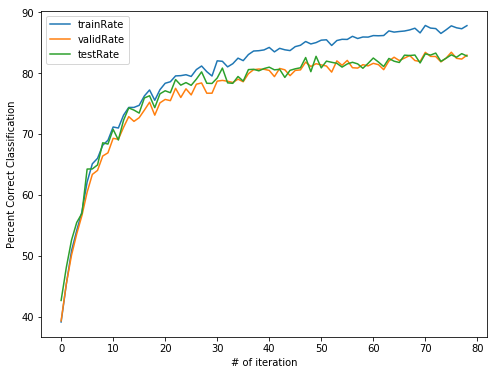

In [27]:
# import matplotlib.pyplot as plt
# x = [i for i in range(79)]
# plt.figure(figsize = (8,6))
# trainRate, = plt.plot(x, train_accu)
# validRate, = plt.plot(x, valid_accu)
# testRate, = plt.plot(x, test_accu)
# plt.legend([trainRate, validRate, testRate], ['trainRate', 'validRate', 'testRate'])
# plt.xlabel('# of iteration')
# plt.ylabel('Percent Correct Classification')
# # plt.title('Percent Correct Classification of CNN-1')
# plt.show()

In [ ]:
correct = 0
total = 0
for data in testloader2:
    images, labels = data
    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()

print('Accuracy of the network on the 10000 test images: %5.2f %%' % (
    100.0 * correct / total))

In [ ]:
import matplotlib.pyplot as plt
x = [i for i in range(epoch)]
plt.figure(figsize = (8,6))
trainRate, = plt.plot(x, train.numpy()[:epoch])
validRate, = plt.plot(x, valid.numpy()[:epoch])
testRate, = plt.plot(x, test.numpy()[:epoch])
plt.legend([trainRate, validRate, testRate], ['trainRate', 'validRate', 'testRate'])
plt.xlabel('# of iteration')
plt.ylabel('Percent Correct Classification')
plt.title('Percent Correct Classification of CNN-1')
plt.show()